In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.dates as mdates

In [2]:
month_day_fmt = mdates.DateFormatter('%m/%d')

# (Support functions)

In [3]:
def autolabel_above(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = int(round(rect.get_height()))
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, rect.get_height()),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

In [4]:
def autolabel_beside(rects):
    """Attach a text label to the right of each bar in *rects*, displaying its width."""
    for rect in rects:
        width = int(round(rect.get_width()))
        ax.annotate('{}'.format(width),
                    xy=(rect.get_width(), rect.get_y() + rect.get_height() / 2),
                    xytext=(5, -5),
                    textcoords="offset points",
                    ha='center', va='bottom')

# Get fhm-data

In [5]:
day_df = pd.read_pickle('day.pkl')
total_df = pd.read_pickle('total.pkl')

# Folkhälsomyndigheten states that data is incomplete for last 2 days, remove those along with 'unknown data'
day_complete_df = day_df[:-3]

In [6]:
def get_subdf(col):
    return total_df.loc[total_df[col].notna(), 
                        [col, 'total_cases', 'cases_per_100k', 'total_icu', 'total_deceased']]
region_df = get_subdf('region')
age_df = get_subdf('agegroup')
sex_df = get_subdf('sex')

# Get populations by groups, Source: [SCB]('http://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__BE__BE0101__BE0101A/BefolkManad')

In [7]:
pop_2020 = pd.read_pickle('external/pop_2020-02.pkl')
pop_agegroup = pop_2020.loc[pop_2020['region'] == 'Riket'].groupby('agegroup')['value'].sum()
pop_sex = pop_2020.loc[pop_2020['region'] == 'Riket'].groupby('sex')['value'].sum()
pop_regions = pop_2020.groupby('region').sum()['value']
pop_regions = pop_regions.loc[pop_regions.index != 'Riket']

In [8]:
reindices = [ndx[:-4] if ndx[:-4][-1] != 's' else ndx[:-5] for ndx in pop_regions.index]
reindices[5] = 'Jämtland_Härjedalen'
reindices[12] = 'Sörmland'
reindices[-3] = 'Västra_Götaland'
pop_regions.index = reindices

In [9]:
region_df['population'] = pop_regions.to_numpy()
age_df.loc[:len(age_df)-2, 'population'] = pop_agegroup.to_numpy()
age_df.loc[age_df['agegroup'] == 'unknown', 'population'] = 0

sex_df.loc[sex_df['sex'] == 'Man', 'population'] = pop_sex['män']
sex_df.loc[sex_df['sex'] == 'Kvinna', 'population'] = pop_sex['kvinnor']
sex_df.loc[sex_df['sex'] == 'unknown', 'population'] = 0

### Calculate percentages of cases

In [10]:
male_per_100k = 1000 * 100 * total_df.loc[total_df.sex == 'Man', 'total_cases']/pop_sex[1]
female_per_100k = 1000 * 100 * total_df.loc[total_df.sex == 'Kvinna', 'total_cases']/pop_sex[0]
sex_df.loc[sex_df.sex == 'Man', 'cases_per_100k'] = male_per_100k
sex_df.loc[sex_df.sex == 'Kvinna', 'cases_per_100k'] = female_per_100k

In [11]:
age_df.loc[age_df.agegroup == '80-90', 'agegroup'] = '80-89'
age_cases_per_100k = 1000 * 100 * age_df.total_cases[:-1]/pop_agegroup.to_numpy()
age_df['cases_per_100k'] = age_cases_per_100k
age_df['cases_percentage'] = age_df['cases_per_100k']/1000
age_df['deceased_percentage'] = 100 * age_df['total_deceased']/age_df['total_cases']
age_df['icu_percentage'] = 100 * age_df['total_icu']/age_df['total_cases']

In [12]:
age_df

,agegroup,total_cases,cases_per_100k,total_icu,total_deceased,population,cases_percentage,deceased_percentage,icu_percentage
0,0-9,476,38.212460,8,1,1245667.0,0.038212,0.210084,1.680672
1,10-19,3075,260.765812,14,0,1179219.0,0.260766,0.000000,0.455285
2,20-29,10903,819.780600,91,8,1329990.0,0.819781,0.073374,0.834633
3,30-39,11666,852.536600,115,16,1368387.0,0.852537,0.137151,0.985771
4,40-49,12920,994.798865,280,45,1298755.0,0.994799,0.348297,2.167183
5,50-59,14050,1082.960977,634,157,1297369.0,1.082961,1.117438,4.512456
6,60-69,8072,729.206284,751,380,1106957.0,0.729206,4.707631,9.303766
7,70-79,5736,582.137040,490,1204,985335.0,0.582137,20.990237,8.542538
8,80-89,6462,1499.084821,101,2323,431063.0,1.499085,35.948623,1.562984
9,90+,3496,3655.909481,3,1459,95626.0,3.655909,41.733410,0.085812


### Compute running averages

In [13]:
day_complete_df = day_complete_df.assign(
    rolling_5_cases=day_df.rolling(5, min_periods=3, center=True).mean()['total_cases'],
    rolling_7_cases=day_df.rolling(7, min_periods=3, center=True).mean()['total_cases'],
)
for region in pop_regions.index:
    day_complete_df[f'{region}_rolling_5'] = day_df[region].rolling(5, min_periods=3, center=True).mean()

In [14]:
day_complete_percent = day_complete_df.copy(deep=True)
for col in pop_regions.index:
    day_complete_percent[col] = 100 * day_complete_df[col]/pop_regions[col]
    day_complete_percent[f'{col}_rolling_5'] = 100 * day_complete_df[f'{col}_rolling_5']/pop_regions[col]

# Verify that summations are correct over regions

In [15]:
assert region_df.total_cases.sum() == day_df.total_cases.sum(), "Total cases by region doesn't match total number of cases"
assert region_df.total_deceased.sum() == day_df.total_deceased.sum(), "Total deceased by region doesn't match total number of deceased"
assert region_df.total_icu.sum() == day_df.total_icu.sum(), "Total icu by region doesn't match total number of icu"

## There should be no assertion errors!
## Otherwise there is discrepancies in total data report and daily data

# Get overall status

In [16]:
print(f'Totalt antal smittade: {int(day_df.total_cases.sum())}')
print(f'Totalt antal dödsfall: {int(day_df.total_deceased.sum())}')
print(f'Totalt antal intensivvårdade: {int(day_df.total_icu.sum())}')
print()
print(f'Procentuell andel positivt testade av befolkningen: {100*day_df.total_cases.sum()/pop_agegroup.sum():.3}%')
print(f'Ratio dödsfall/positivt testade: {100*day_df.total_deceased.sum()/day_df.total_cases.sum():.3}%')

Totalt antal smittade: 76877
Totalt antal dödsfall: 5593
Totalt antal intensivvårdade: 2487

Procentuell andel positivt testade av befolkningen: 0.744%
Ratio dödsfall/positivt testade: 7.28%


# Plots by sex

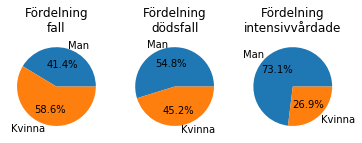

In [17]:
fig, axs = plt.subplots(1, 3)
axs[0].pie(sex_df.total_cases[:-1], labels=sex_df.sex[:-1], autopct='%1.1f%%')
_ = axs[0].set(title='Fördelning\nfall')

axs[1].pie(sex_df.total_deceased[:-1], labels=sex_df.sex[:-1], autopct='%1.1f%%')
_ = axs[1].set(title='Fördelning\ndödsfall')

axs[2].pie(sex_df.total_icu[:-1], labels=sex_df.sex[:-1], autopct='%1.1f%%')
_ = axs[2].set(title='Fördelning\nintensivvårdade')

# Age-group plots

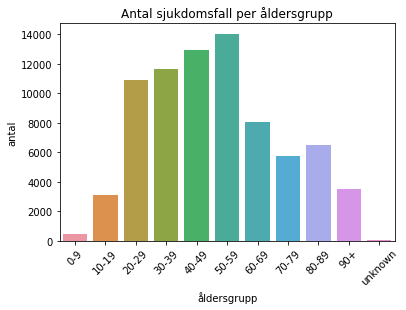

In [18]:
ax = sns.barplot('agegroup', 'total_cases', data=age_df)
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal sjukdomsfall per åldersgrupp', xlabel='åldersgrupp', ylabel='antal')

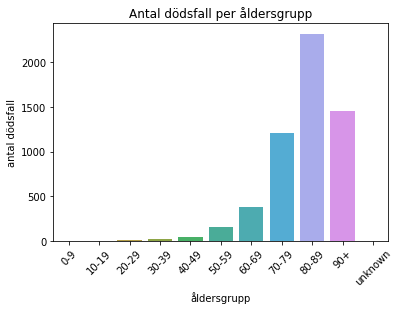

In [19]:
ax = sns.barplot('agegroup', 'total_deceased', data=age_df)
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal dödsfall per åldersgrupp', xlabel='åldersgrupp', ylabel='antal dödsfall')

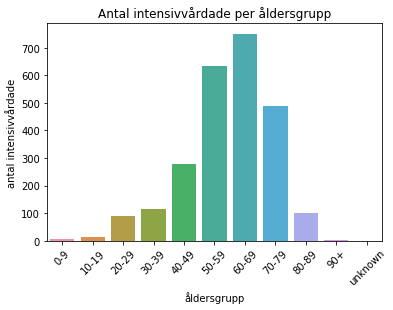

In [20]:
ax = sns.barplot('agegroup', 'total_icu', data=age_df)
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal intensivvårdade per åldersgrupp', xlabel='åldersgrupp', ylabel='antal intensivvårdade')

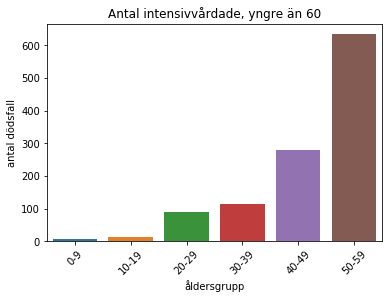

In [21]:
ax = sns.barplot('agegroup', 'total_icu', data=age_df.loc[:5])
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal intensivvårdade, yngre än 60', xlabel='åldersgrupp', ylabel='antal dödsfall')

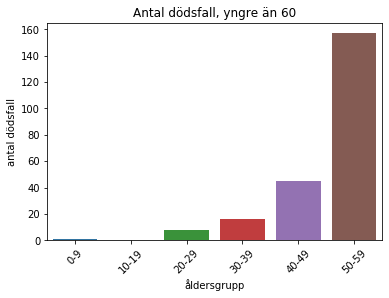

In [22]:
ax = sns.barplot('agegroup', 'total_deceased', data=age_df.loc[:5])
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal dödsfall, yngre än 60', xlabel='åldersgrupp', ylabel='antal dödsfall')

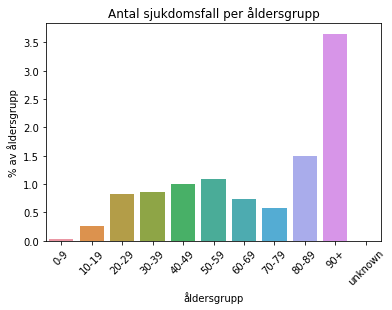

In [23]:
ax = sns.barplot('agegroup', 'cases_percentage', data=age_df)
ax.set_xticklabels(age_df.agegroup, rotation=45)
_ = ax.set(title='Antal sjukdomsfall per åldersgrupp', xlabel='åldersgrupp', ylabel='% av åldersgrupp')

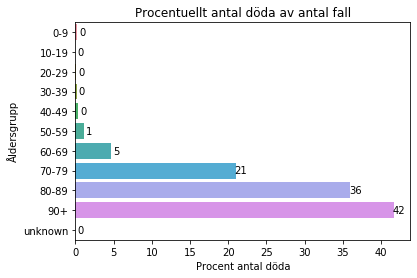

In [24]:
ax = sns.barplot('deceased_percentage', 'agegroup', data=age_df)
autolabel_beside(ax.patches)
_ = ax.set(title='Procentuellt antal döda av antal fall', xlabel='Procent antal döda', ylabel='Åldersgrupp')

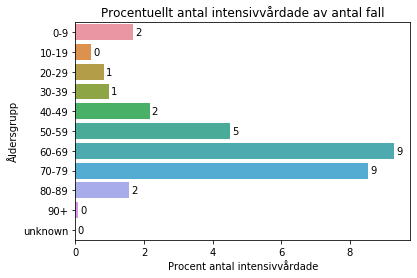

In [25]:
ax = sns.barplot('icu_percentage', 'agegroup', data=age_df)
autolabel_beside(ax.patches)
_ = ax.set(title='Procentuellt antal intensivvårdade av antal fall', xlabel='Procent antal intensivvårdade', ylabel='Åldersgrupp')

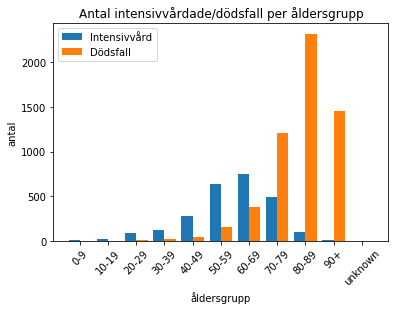

In [26]:
xpos = np.arange(len(age_df.icu_percentage))
width = .4

fig, ax = plt.subplots()
rects1 = plt.bar(xpos-width/2, age_df.total_icu, width, label='Intensivvård')
rects2 = plt.bar(xpos+width/2, age_df.total_deceased, width, label='Dödsfall')

ax.set_xticks(xpos)
ax.set_xticklabels(age_df.agegroup, rotation=45)
ax.legend()
_ = ax.set(title='Antal intensivvårdade/dödsfall per åldersgrupp', xlabel='åldersgrupp', ylabel='antal')

In [27]:
# plt.pie(age_df.total_icu, explode=[0.03 for _ in age_df.agegroup], labels=age_df.agegroup, shadow=True, autopct='%1.0f%%')

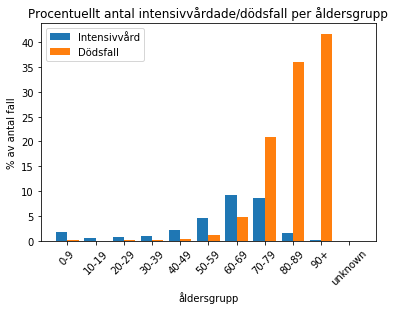

In [28]:
xpos = np.arange(len(age_df.icu_percentage))
width = .4

fig, ax = plt.subplots()
rects1 = plt.bar(xpos-width/2, age_df.icu_percentage, width, label='Intensivvård')
rects2 = plt.bar(xpos+width/2, age_df.deceased_percentage, width, label='Dödsfall')

ax.set_xticks(xpos)
ax.set_xticklabels(age_df.agegroup, rotation=45)
ax.legend()
_ = ax.set(title='Procentuellt antal intensivvårdade/dödsfall per åldersgrupp', xlabel='åldersgrupp', ylabel='% av antal fall')

# New cases, daily plots

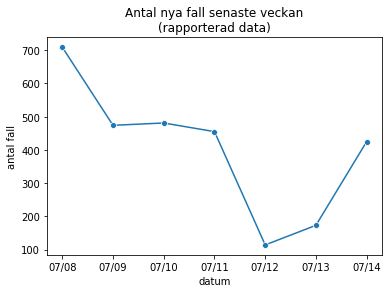

In [29]:
ax = sns.lineplot('date', 'total_cases', data=day_complete_df[-7:], marker='o')
ax.xaxis.set_major_formatter(month_day_fmt)
_ = ax.set(title='Antal nya fall senaste veckan\n(rapporterad data)', xlabel='datum', ylabel='antal fall')

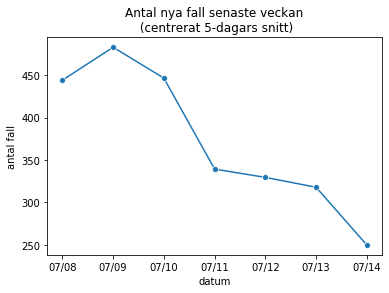

In [30]:
ax = sns.lineplot('date', 'rolling_5_cases', data=day_complete_df[-7:], marker='o')
ax.xaxis.set_major_formatter(month_day_fmt)
_ = ax.set(title='Antal nya fall senaste veckan\n (centrerat 5-dagars snitt)', xlabel='datum', ylabel='antal fall')

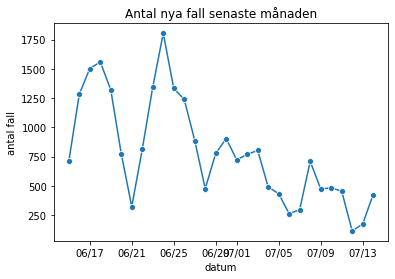

In [31]:
ax = sns.lineplot('date', 'total_cases', data=day_complete_df[-30:], marker='o')
ax.xaxis.set_major_formatter(month_day_fmt)
_ = ax.set(title='Antal nya fall senaste månaden', xlabel='datum', ylabel='antal fall')

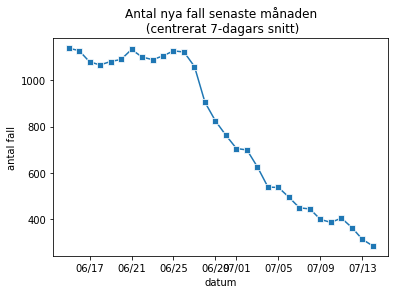

In [32]:
ax = sns.lineplot('date', 'rolling_7_cases', data=day_complete_df[-30:], marker='s')
ax.xaxis.set_major_formatter(month_day_fmt)
_ = ax.set(title='Antal nya fall senaste månaden\n (centrerat 7-dagars snitt)', xlabel='datum', ylabel='antal fall')

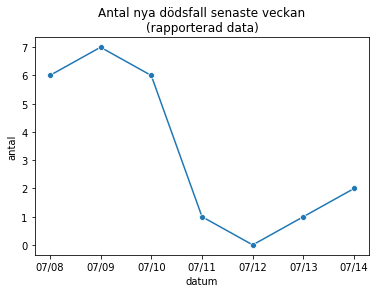

In [33]:
ax = sns.lineplot('date', 'total_deceased', data=day_complete_df[-7:], marker='o')
ax.xaxis.set_major_formatter(month_day_fmt)
_ = ax.set(title='Antal nya dödsfall senaste veckan\n(rapporterad data)', xlabel='datum', ylabel='antal')

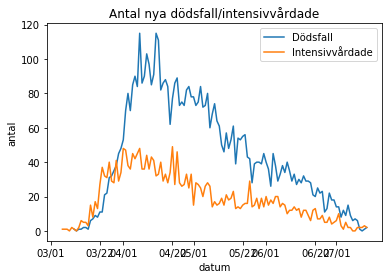

In [34]:
sns.lineplot('date', 'total_deceased', data=day_complete_df)
ax = sns.lineplot('date', 'total_icu', data=day_complete_df)
ax.xaxis.set_major_formatter(month_day_fmt)
ax.set(title='Antal nya dödsfall/intensivvårdade', xlabel='datum', ylabel='antal')
_ = ax.legend(['Dödsfall', 'Intensivvårdade'])

# De intressantaste regionerna...

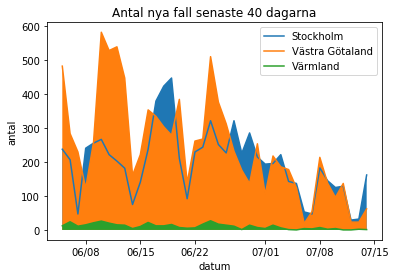

In [35]:
sns.lineplot('date', 'Stockholm', data=day_complete_df[-40:])
sns.lineplot('date', 'Västra_Götaland', data=day_complete_df[-40:])
ax = sns.lineplot('date', 'Värmland', data=day_complete_df[-40:])

ax.fill_between(day_complete_df[-40:].date, day_complete_df[-40:]['Stockholm'])
ax.fill_between(day_complete_df[-40:].date, day_complete_df[-40:]['Västra_Götaland'])
ax.fill_between(day_complete_df[-40:].date, day_complete_df[-40:]['Värmland'])

ax.xaxis.set_major_formatter(month_day_fmt)
ax.set(title='Antal nya fall senaste 40 dagarna', xlabel='datum', ylabel='antal')
_ = ax.legend(['Stockholm', 'Västra Götaland', 'Värmland'])

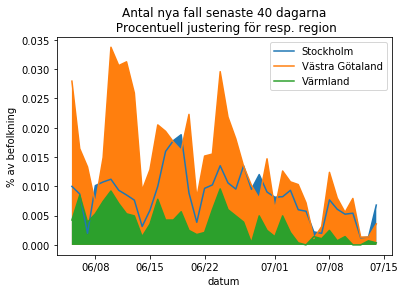

In [36]:
sns.lineplot('date', 'Stockholm', data=day_complete_percent[-40:])
sns.lineplot('date', 'Västra_Götaland', data=day_complete_percent[-40:])
ax = sns.lineplot('date', 'Värmland', data=day_complete_percent[-40:])

ax.fill_between(day_complete_percent[-40:].date, day_complete_percent[-40:]['Stockholm'])
ax.fill_between(day_complete_percent[-40:].date, day_complete_percent[-40:]['Västra_Götaland'])
ax.fill_between(day_complete_percent[-40:].date, day_complete_percent[-40:]['Värmland'])

ax.xaxis.set_major_formatter(month_day_fmt)
ax.set(title='Antal nya fall senaste 40 dagarna\n Procentuell justering för resp. region', xlabel='datum', ylabel='% av befolkning')
_ = ax.legend(['Stockholm', 'Västra Götaland', 'Värmland'])

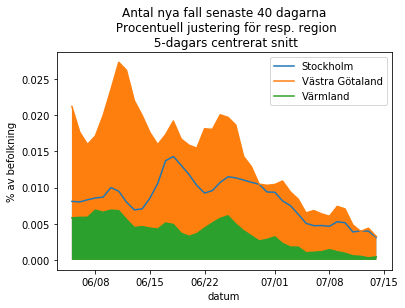

In [37]:
sns.lineplot('date', 'Stockholm_rolling_5', data=day_complete_percent[-40:])
sns.lineplot('date', 'Västra_Götaland_rolling_5', data=day_complete_percent[-40:])
ax = sns.lineplot('date', 'Värmland_rolling_5', data=day_complete_percent[-40:])

ax.fill_between(day_complete_percent[-40:].date, day_complete_percent[-40:]['Stockholm_rolling_5'])
ax.fill_between(day_complete_percent[-40:].date, day_complete_percent[-40:]['Västra_Götaland_rolling_5'])
ax.fill_between(day_complete_percent[-40:].date, day_complete_percent[-40:]['Värmland_rolling_5'])

ax.xaxis.set_major_formatter(month_day_fmt)
ax.set(title='Antal nya fall senaste 40 dagarna\n Procentuell justering för resp. region\n 5-dagars centrerat snitt', 
       xlabel='datum', ylabel='% av befolkning')
_ = ax.legend(['Stockholm', 'Västra Götaland', 'Värmland'])

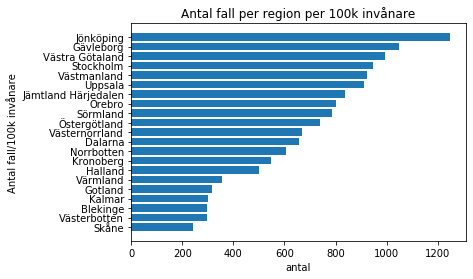

In [38]:
ordered_region = region_df.sort_values(by='cases_per_100k')
ypos = np.arange(len(ordered_region.region))

fig, ax = plt.subplots()
ax.barh(ypos, ordered_region.cases_per_100k)
ax.set_yticks(ypos)
ax.set_yticklabels(ordered_region.region)
_ = ax.set(title='Antal fall per region per 100k invånare', ylabel='Antal fall/100k invånare', xlabel='antal')